In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#mini meta data
t_metaData = pd.read_csv('/content/drive/MyDrive/MetaData/train.csv')
v_metaData = pd.read_csv('/content/drive/MyDrive/MetaData/train.csv')
print(pd.unique(t_metaData.target))
print(pd.unique(t_metaData.benign_malignant))

[0 1]
['benign' 'malignant']


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from keras.utils import load_img,img_to_array
from keras.preprocessing.image import ImageDataGenerator #, array_to_img, img_to_array, load_img
from keras.applications import ResNet50, DenseNet121, efficientnet
from keras.optimizers import SGD, Adam
from keras.layers import Input,GlobalAveragePooling2D, Flatten, Dense, BatchNormalization, Dropout, GlobalMaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.metrics import AUC

In [ ]:
train_data_dir = '/content/drive/MyDrive/data/train'
validation_data_dir = '/content/drive/MyDrive/data/validation'

nb_train_samples = 30076
nb_validation_samples = 3050
img_width, img_height = 150, 150 
BATCH_SIZE = 32

train_image_generator = ImageDataGenerator(
                                                rescale=1./255,
                                                rotation_range=10,  # Random rotation between -10 and 10 degrees
                                                width_shift_range=0.1,  # Randomly shift the width by a maximum of 10%
                                                height_shift_range=0.1,  # Randomly shift the height by a maximum of 10%
                                                shear_range=0.1,  # Shear the image by a maximum of 10%
                                                zoom_range=0.1,  # Zoom in or out by a maximum of 10%
                                                horizontal_flip=True,  # Randomly flip the images horizontally
                                                vertical_flip=False,  # Don't flip the images vertically
)
validation_image_generator = ImageDataGenerator(rescale=1./255)  #Generator for our validation data ## means that all the pixel values of the images in the validation set will be divided by 255 to bring them in the range [0, 1]

train_data_gen = train_image_generator.flow_from_directory(
    directory=train_data_dir,
    target_size=(img_width, img_height),
    batch_size=BATCH_SIZE,
    classes=['benign train RESIZE', 'train malignant 534'],
    class_mode='categorical'
)

val_data_gen = validation_image_generator.flow_from_directory(
    directory=validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=BATCH_SIZE,
    classes=['benign 3000 RESIZE', 'validation malignant 50'],
    class_mode='categorical'
)

Found 30076 images belonging to 2 classes.
Found 3050 images belonging to 2 classes.


In [ ]:
y = ['benign train RESIZE', 'train malignant 534']
class_names = np.unique(y)

class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=class_names, y=y)
class_weights_dict = dict(enumerate(class_weights))

print(class_weights_dict)
print(train_data_gen.class_indices)

{0: 1.0, 1: 1.0}
{'benign train RESIZE': 0, 'train malignant 534': 1}


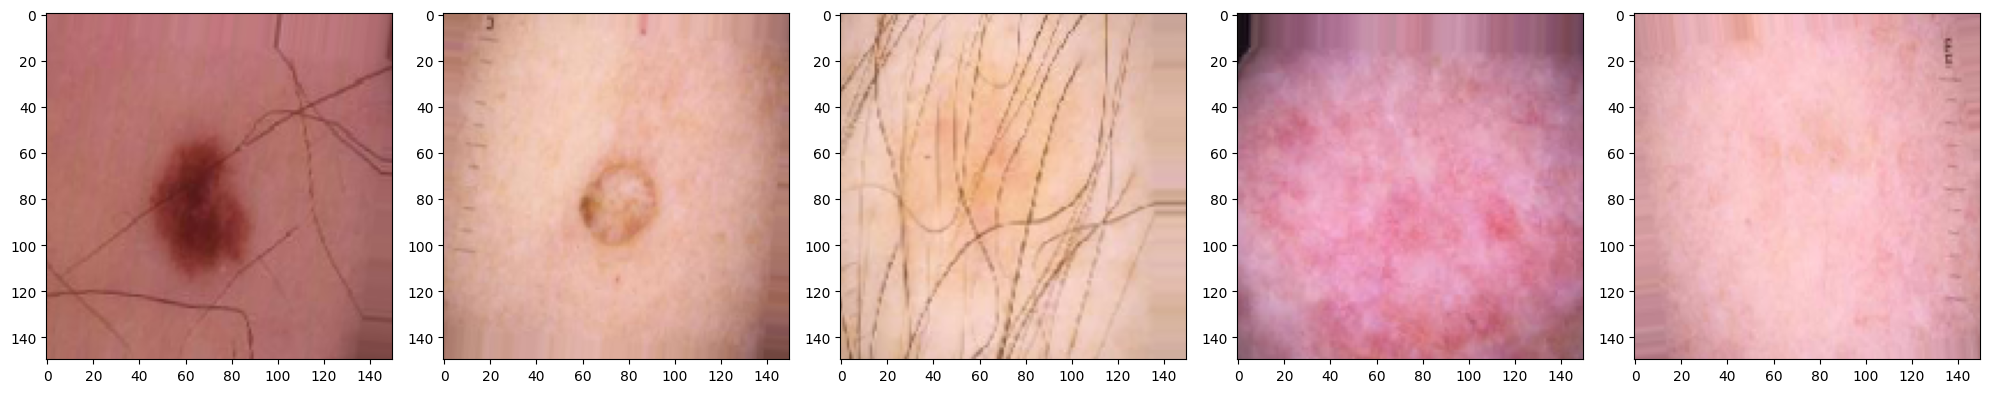

In [ ]:
sample_training_images, _ = next(train_data_gen) 
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
plotImages(sample_training_images[:5])  # Plot images 0-4

In [ ]:
# top layer
base_model = DenseNet121(
            weights='imagenet',  # Load weights pre-trained on ImageNet.
            #input_shape=(img_width,img_height,3),
            include_top=False)  # Do not include the ImageNet classifier at the top.
base_model.trainable = False

inputs = Input(shape=(img_width,img_height,3))
x1 = base_model(inputs, training=False)
x2 = GlobalAveragePooling2D()(x1)
x3 = Dense(10,activation="relu")(x2)
x4 = Dense(10,activation="relu")(x3)
outputs = Dense(2, activation='softmax')(x4)
model = tf.keras.Model(inputs, outputs)

opt = Adam(0.0001)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy', AUC()]) #tf.keras.losses.SparseCategoricalCrossentropy()

print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 10)                10250     
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 2)                 22        
                                                           

In [ ]:
EPOCHS = 10

checkpoint_filepath = '/content/drive/MyDrive/modelsCheckpoints/model_1.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    verbose=1, #noisy
    save_best_only=True, #only saves when the model is considered the "best"
    save_weights_only=True, #only the model's weights will be saved
    monitor='val_accuracy', #saving according to what, when the model is not traind as we want - should we save according to the train and not the validation?
    mode='max', #very important!-check if you need val_acc or val_loss more
    save_freq='epoch') #saving frequency

#its the last training of the model befor using it to predict
history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(nb_train_samples / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(nb_validation_samples / float(BATCH_SIZE))),
    callbacks=[model_checkpoint_callback],
    class_weight=class_weights_dict
)

Epoch 1/10
1880/1880 [==============================] - ETA: 0s - loss: 0.1509 - accuracy: 0.9765 - auc_1: 0.9803 
Epoch 1: val_accuracy improved from -inf to 0.98361, saving model to /content/drive/MyDrive/modelsCheckpoints/model_1.h5
1880/1880 [==============================] - 27772s 15s/step - loss: 0.1509 - accuracy: 0.9765 - auc_1: 0.9803 - val_loss: 0.0819 - val_accuracy: 0.9836 - val_auc_1: 0.9881
Epoch 2/10
1880/1880 [==============================] - ETA: 0s - loss: 0.0783 - accuracy: 0.9823 - auc_1: 0.9926
Epoch 2: val_accuracy did not improve from 0.98361
1880/1880 [==============================] - 573s 305ms/step - loss: 0.0783 - accuracy: 0.9823 - auc_1: 0.9926 - val_loss: 0.0654 - val_accuracy: 0.9836 - val_auc_1: 0.9959
Epoch 3/10
1880/1880 [==============================] - ETA: 0s - loss: 0.0693 - accuracy: 0.9824 - auc_1: 0.9955
Epoch 3: val_accuracy improved from 0.98361 to 0.98426, saving model to /content/drive/MyDrive/modelsCheckpoints/model_1.h5
1880/1880 [====

In [ ]:
!ls /content/drive/MyDrive/modelsCheckpoints

model_1.h5


In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# import torch

# model_save_name = 'classifier.pt'
# path = F"/content/gdrive/My Drive/{model_save_name}" 
# torch.save(model.state_dict(), path)

# # #load
# # model_save_name = 'classifier.pt'
# # path = F"/content/gdrive/My Drive/{model_save_name}"
# # model.load_state_dict(torch.load(path))

In [ ]:
# #model.save('my_model.h5')

# # Save the entire model as a SavedModel.
# !mkdir -p saved_model
# model.save('saved_model/my_model') 

In [ ]:
channels =3
#model = load_model("gdrive/MyDrive/data_sets/cats_dogs/CatDog_train.h5")
counter = 15

for category in ["benign 3000 RESIZE/","validation malignant 50/"]: 

  path = "/content/drive/MyDrive/data/validation/" +category
  for i in os.listdir(path)[0:15]:
      img = load_img(path+i, grayscale=False,target_size=(img_width, img_height))

      plt.matshow(img)
      plt.show()
      print(i)
      img = img_to_array(img)
      img = img.reshape(1, img_width, img_height, channels).astype('float32')
      img = img / 255.0

      preds = model.predict(img)
      print("predictions:{} category:{}".format(preds,np.argmax(preds)))
  

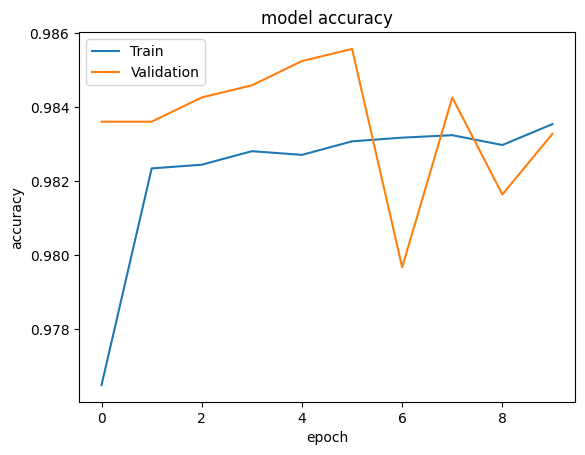

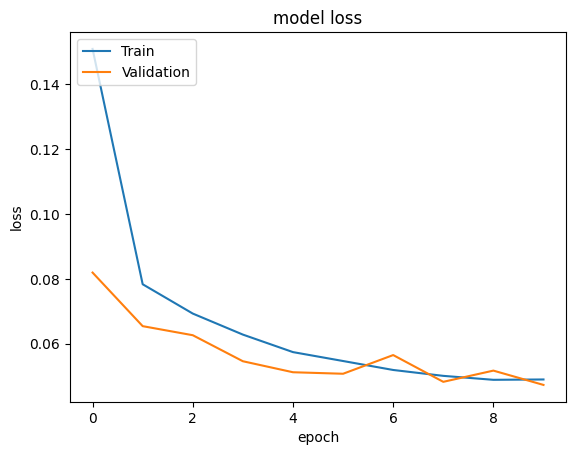

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()